## Ⅰ. Intro

### 1. 테이블의 내용
1. 고객이 각 귀속년도별
1. 근로 / 사업 / 기타 소득에 대한 예상환급액과 수수료를 조회한 뒤
1. 결제를 하거나 하지 않은 여부를 저장

### 2. 컬럼 정보
- age: 고객의 만 나이입니다. 
- gender: 고객의 성별입니다.
- year: 소득이 발생한 연도(귀속년도)입니다.
- refund: 예상환급액입니다.
- fee: 수수료입니다.
- has_paid: 수수료를 결제했는지의 여부
- income_근로: 고객의 근로소득(월급/일용직급여)
- income_사업: 고객의 사업소득(프리랜서 소득)
- income_기타: 고객의 기타소득(그외 기타 소득)

### 3. 질문

- 고객의 결제여부에 영향을 미치는 요인들은 무엇인가요? 
- 고객의 수수료 결제금액의 합을 높히기 위해서는 어떻게 해야 할까요?

### 4. 개념파악 
- 납부세액 혹은 환급세액의 결정방법
- 소득을 3범주로 하여, 기장의무가 달라진다.  
https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=fobi52&logNo=221270380307

### 5. EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df=pd.read_csv('Jobis_3o3.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
age          100000 non-null float64
gender       100000 non-null object
year         100000 non-null int64
refund       100000 non-null float64
fee          100000 non-null float64
has_paid     100000 non-null bool
income_근로    40791 non-null float64
income_사업    78227 non-null float64
income_기타    25260 non-null float64
dtypes: bool(1), float64(6), int64(1), object(1)
memory usage: 6.2+ MB


In [4]:
df.describe()

,age,year,refund,fee,income_근로,income_사업,income_기타
count,100000.00000,100000.000000,1.000000e+05,100000.000000,4.079100e+04,7.822700e+04,2.526000e+04
mean,29.00096,2018.111300,2.081422e+05,7247.641000,6.432597e+06,1.511712e+06,6.362834e+05
std,7.76819,1.495812,3.071744e+05,11926.896979,6.583716e+06,2.449810e+06,1.484947e+06
min,15.00000,2015.000000,-8.265000e+06,400.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,24.00000,2017.000000,3.300000e+04,400.000000,1.616000e+06,1.770000e+05,8.200000e+04
50%,27.00000,2018.000000,9.900000e+04,4300.000000,4.507000e+06,6.190000e+05,2.130000e+05
75%,31.00000,2019.000000,2.540000e+05,8500.000000,9.301000e+06,1.601000e+06,5.820000e+05
max,81.00000,2020.000000,7.725000e+06,307000.000000,1.823350e+08,3.993400e+07,6.281000e+07


#### 1) 지불여부를 숫자로 바꾸고 수수료를 곱한 새로운 변수(Target)를 생성한다.
#### 2) 환급액에서 수수료를 뺀 gain이라는 변수를 생성하고, profit의 비율을 변수 pr로 생성한다.

In [5]:
df['has_paid']=df['has_paid'].replace(True,1).replace(False,0)

In [6]:
df['Target']=df.has_paid*df.fee

#### 3) 환급액과 수수료를 고려한 순 환급액과 이익률 변수를 생성

In [7]:
pr=(df.refund-df.fee)/df.refund
df['pr']=pr
gain=df.refund-df.fee
df['gain']=gain

#### 4) 나이를 카테고리화

- 나이를 카테고리화하는 기준으로는 통곗값기반 이상값 탐색 알고리즘의 값 범위를 활용하였다.  
    다만, 상위 이상값들의 결제금액합이 전체 데이터의 19%에 해당해 상위 이상값은 두그룹으로 나눴다.

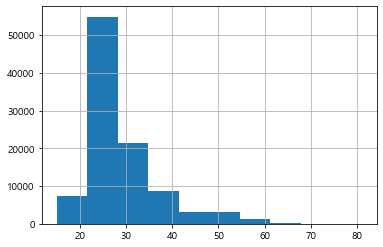

In [8]:
df.age.hist()

In [9]:
IQR= df.age.quantile(0.75)-df.age.quantile(0.25)
Q3= df.age.quantile(0.25)
Q1=df.age.quantile(0.75)

In [10]:
df.query("(age > @Q1-1.5*@IQR) and (age < @Q3+1.5*@IQR)").age.describe()

count    79872.000000
mean        26.467085
std          3.310020
min         21.000000
25%         24.000000
50%         26.000000
75%         29.000000
max         34.000000
Name: age, dtype: float64

In [11]:
# 이상값들의 총 결제금액에서 차지하는 비중(%) -상위
str(round((df.query("age > 34").Target.sum()/df.Target.sum())*100,2))+'%'

'19.56%'

In [12]:
# 하위
str(round((df.query("age < 21").Target.sum()/df.Target.sum())*100,2))+'%'

'2.45%'

In [13]:
df.query("age > 34").age.quantile(0.75)

48.0

In [14]:
# 나이 카테고리 변수 생성
cat_1=pd.cut(df.age,bins=[-1,21,24,26,29,34,37,48,100]).astype('str').str.rstrip(']').str.lstrip('(')
df['ag_cat']=cat_1

- 추가로 각 소득원의 유무와 각 데이터가 소득원을 몇개가지고 있는지도 변수로 생성한다.

In [15]:
df['근로yn']=df.income_근로.notnull()
df['사업yn']=df.income_사업.notnull()
df['기타yn']=df.income_기타.notnull()
df['소득notnull여부']=pd.concat([df.income_근로.notnull(),df.income_사업.notnull(),df.income_기타.notnull()],axis=1).sum(1).astype('str')

#### 5) 성별컬럼 결측값처리

- 성별 값이 '-'인 데이터는 22건이 존재한다. 그리고 모두 소득원에 대한 정보가 없다. (위 3가지 컬럼에 집계되지 않는 소득이 있는 것으로 판단한다.) 
- 이중 실제 결제 된 데이터가 4건에 해당한다. 이는, 총 결제데이터 6만4643건의 데이터규모에서 극히 일부분이며, 결제 여부를 고려하지 않는 10만건 중에 성별 결측치 데이터는 극 소수이기 때문에 제외한다.

In [16]:
df.loc[df.gender=='-',:]

,age,gender,year,refund,fee,has_paid,income_근로,income_사업,income_기타,Target,pr,gain,ag_cat,근로yn,사업yn,기타yn,소득notnull여부
2613,27.0,-,2016,559000.0,12800.0,0.0,NaN,NaN,NaN,0.0,0.977102,546200.0,"26, 29",False,False,False,0
4101,27.0,-,2017,209000.0,4300.0,0.0,NaN,NaN,NaN,0.0,0.979426,204700.0,"26, 29",False,False,False,0
9574,42.0,-,2015,175000.0,4300.0,0.0,NaN,NaN,NaN,0.0,0.975429,170700.0,"37, 48",False,False,False,0
20536,26.0,-,2017,845000.0,25100.0,0.0,NaN,NaN,NaN,0.0,0.970296,819900.0,"24, 26",False,False,False,0
28211,26.0,-,2016,650000.0,12800.0,0.0,NaN,NaN,NaN,0.0,0.980308,637200.0,"24, 26",False,False,False,0
36217,27.0,-,2018,124000.0,3400.0,0.0,NaN,NaN,NaN,0.0,0.972581,120600.0,"26, 29",False,False,False,0
37674,27.0,-,2015,252000.0,8500.0,0.0,NaN,NaN,NaN,0.0,0.966270,243500.0,"26, 29",False,False,False,0
38223,53.0,-,2015,6000.0,400.0,0.0,NaN,NaN,NaN,0.0,0.933333,5600.0,"48, 100",False,False,False,0
38441,23.0,-,2018,110000.0,3000.0,0.0,NaN,NaN,NaN,0.0,0.972727,107000.0,"21, 24",False,False,False,0
41454,41.0,-,2015,122000.0,4300.0,1.0,NaN,NaN,NaN,4300.0,0.964754,117700.0,"37, 48",False,False,False,0


In [17]:
df.query("has_paid==1").shape[0]

64643

In [19]:
df.query("refund <0 and has_paid ==1.0")

,age,gender,year,refund,fee,has_paid,income_근로,income_사업,income_기타,Target,pr,gain,ag_cat,근로yn,사업yn,기타yn,소득notnull여부
10034,34.0,M,2015,-231000.0,8500.0,1.0,8989000.0,1714000.0,NaN,8500.0,1.036797,-239500.0,"29, 34",True,True,False,2
10624,25.0,F,2018,-7000.0,400.0,1.0,7508000.0,28000.0,NaN,400.0,1.057143,-7400.0,"24, 26",True,True,False,2
29515,41.0,F,2017,-10000.0,400.0,1.0,19718000.0,162000.0,128000.0,400.0,1.040000,-10400.0,"37, 48",True,True,True,3
54256,48.0,F,2018,-948000.0,3000.0,1.0,8157000.0,3975000.0,NaN,3000.0,1.003165,-951000.0,"37, 48",True,True,False,2
57756,38.0,F,2017,-107000.0,4300.0,1.0,16619000.0,737000.0,NaN,4300.0,1.040187,-111300.0,"37, 48",True,True,False,2
68881,33.0,M,2016,-322000.0,400.0,1.0,NaN,57000.0,NaN,400.0,1.001242,-322400.0,"29, 34",False,True,False,1
98352,33.0,M,2018,-8265000.0,4300.0,1.0,NaN,690000.0,NaN,4300.0,1.000520,-8269300.0,"29, 34",False,True,False,1


- 환급세액이 마이너스인 경우는 기납부 세액이 결정세액보다 적은 경우이므로 세액의 특성상 존재하는 데이터이다.  
- 이 데이터들은 전체 데이터에서 수수료중 빈도수가 높은 400과 4300과 8500에 해당하는 데이터로 오류 데이터로 보지 않고 삭제하지 않는다.

#### 6) 상관관계 파악

In [21]:
corr=df.corr()

Text(0.5, 1, 'Feature Correlation')

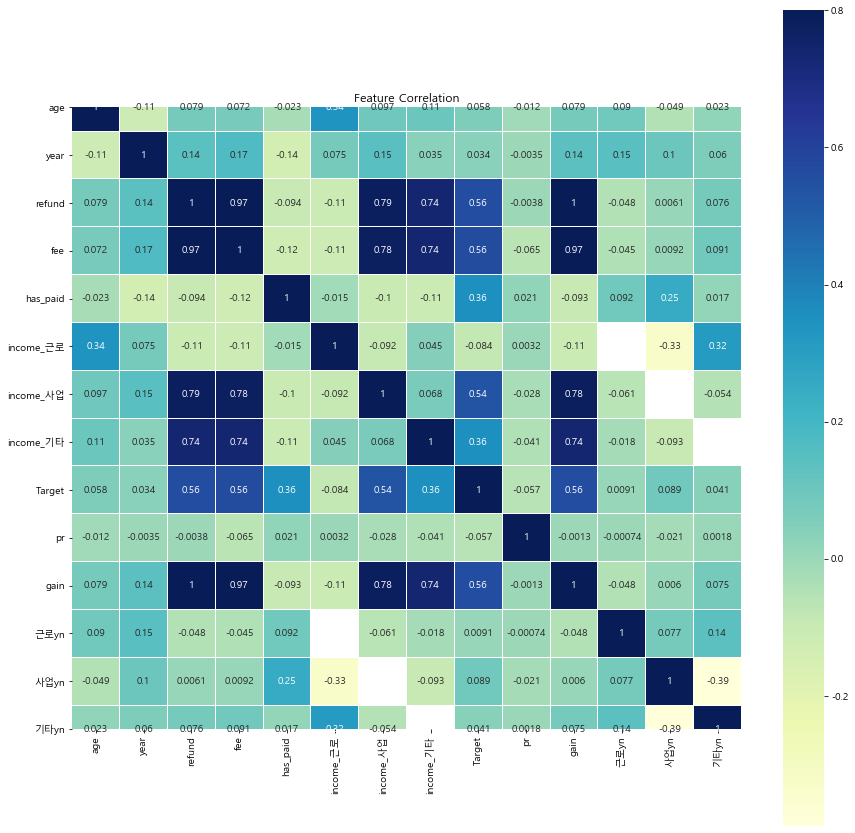

In [22]:
plt.figure(figsize=(15, 15));
sns.heatmap(corr,
            vmax=0.8,
            linewidths=0.01,
            square=True,
            annot=True,
            cmap='YlGnBu');
plt.title('Feature Correlation')

- <U>상관계수 히트맵으로는 결제여부와 약한 상관관계가 있는 사업소득 유무를 제외하면,상관관계 있는 변수는 없는 것으로 판단된다.</U>
- 다만, 결제금액인 Target을 보면, 상식적으로 생각하는 것처럼 환급액과 수수료에 약한 상관관계가 있다.
- 추가로, 사업소득과 결제금액은 뚜렷한 양의 상관관계가 있으며, 기타소득과도 결제금액은 어느정도의 상관관계가 있다.

####  7) 범주형 변수간의 상관관계 파악
#### - Cramer's V
#####   범주형 변수간 상관관계 파악
#####   비교 대상 범주 대상이 3개 이상
https://www.kaggle.com/chrisbss1/cramer-s-v-correlation-matrix

In [24]:
data = df[[i for i in df.columns if i in ('gender','ag_cat','has_paid','근로yn','사업yn','기타yn','소득notnull여부','year')]]

data.head()

,gender,year,has_paid,ag_cat,근로yn,사업yn,기타yn,소득notnull여부
0,F,2019,0.0,"26, 29",True,True,False,2
1,M,2018,1.0,"29, 34",True,False,True,2
2,F,2017,0.0,"26, 29",False,True,False,1
3,M,2019,0.0,"26, 29",False,True,False,1
4,F,2016,1.0,"24, 26",True,True,False,2


In [25]:
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in data.columns :
  data_encoded[i]=label.fit_transform(data[i])

In [26]:
data_encoded.head()

,gender,year,has_paid,ag_cat,근로yn,사업yn,기타yn,소득notnull여부
0,0,4,0,3,1,1,0,2
1,1,3,1,4,1,0,1,2
2,0,2,0,3,0,1,0,1
3,1,4,0,3,0,1,0,1
4,0,1,1,2,1,1,0,2


In [27]:
from scipy.stats import chi2_contingency
import numpy as np


def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

In [28]:
rows= []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded :
    cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df1 = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)



df1

,gender,year,has_paid,ag_cat,근로yn,사업yn,기타yn,소득notnull여부
gender,1.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00
year,0.00,1.00,0.04,0.01,0.03,0.02,0.01,0.03
has_paid,0.00,0.04,1.00,0.00,0.01,0.06,0.00,0.10
ag_cat,0.02,0.01,0.00,1.00,0.04,0.01,0.01,0.02
근로yn,0.00,0.03,0.01,0.04,1.00,0.01,0.02,0.76
사업yn,0.00,0.02,0.06,0.01,0.01,1.00,0.15,0.37
기타yn,0.00,0.01,0.00,0.01,0.02,0.15,1.00,0.26
소득notnull여부,0.00,0.03,0.10,0.02,0.76,0.37,0.26,1.00


Text(0.5, 1, 'Feature Correlation')

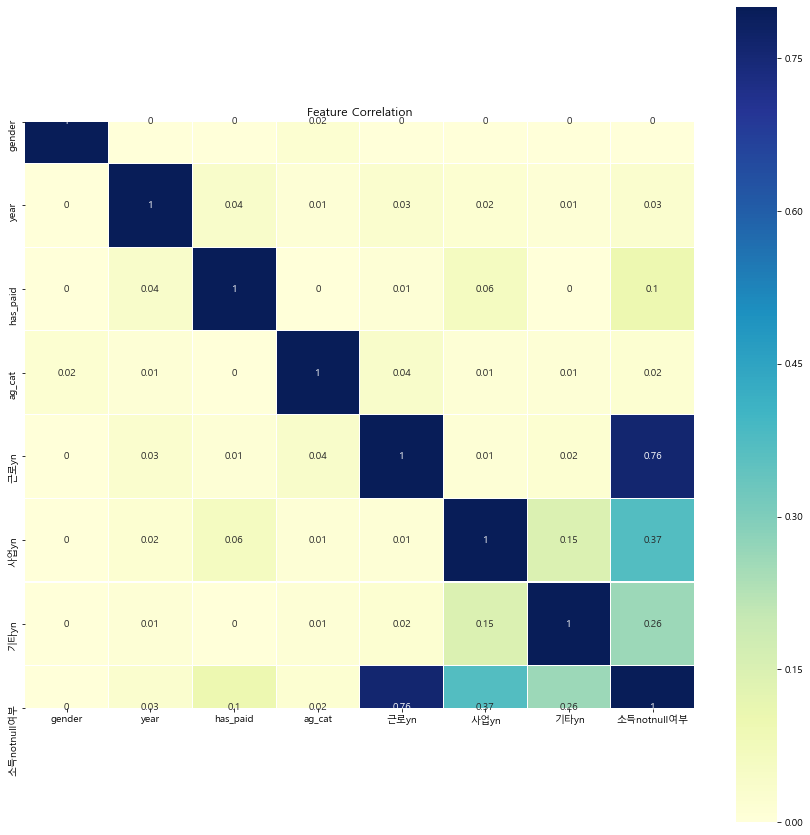

In [29]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.figure(figsize=(15, 15));
sns.heatmap(df1,
            vmax=0.8,
            linewidths=0.01,
            square=True,
            annot=True,
            cmap='YlGnBu');
plt.title('Feature Correlation')

- <U>통계적으로 범주형 변수간의 상관관계는 없는 것으로 판단된다.</U>

***

## Ⅱ. 고객의 결제여부에 영향을 미치는 요인 분석

### 1. 머신러닝 분류 모델을 통해 지불여부에 대해 데이터를 학습시키고 feature importance를 출력한 후 분석을 진행
#### 1) XGB분류모델을 통해 지불여부를 target value로 설정하고, 나머지 변수를 학습

In [30]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [31]:
X=df.reindex(['gender','year', 'refund', 'fee','income_근로','income_사업', 'income_기타','gain','age'],axis=1)
X=X.fillna(0)
y=df.has_paid
X=pd.get_dummies(X)
X.iloc[:,:8]=scaler.fit_transform(X.iloc[:,:8])
X

,year,refund,fee,income_근로,income_사업,income_기타,gain,age,gender_F,gender_M
0,0.8,0.517198,0.000000,0.054850,0.001528,0.000000,0.527427,0.181818,1,0
1,0.6,0.523139,0.004240,0.099224,0.000000,0.028897,0.533400,0.287879,0,1
2,0.4,0.534959,0.036204,0.000000,0.036585,0.000000,0.544823,0.196970,1,0
3,0.8,0.542527,0.051533,0.000000,0.061877,0.000000,0.552237,0.181818,0,1
4,0.2,0.524015,0.012720,0.000000,0.017253,0.000000,0.534126,0.166667,1,0
...,...,...,...,...,...,...,...,...,...,...
99995,0.8,0.535710,0.037508,0.000000,0.000000,0.010826,0.545562,0.181818,1,0
99996,0.8,0.521701,0.002935,0.000000,0.011594,0.000000,0.531959,0.712121,1,0
99997,1.0,0.517448,0.000000,0.043453,0.001352,0.000000,0.527682,0.136364,0,1
99998,0.8,0.519012,0.000000,0.000000,0.005108,0.000000,0.529275,0.136364,0,1


In [32]:
y

0        0.0
1        1.0
2        0.0
3        0.0
4        1.0
        ... 
99995    1.0
99996    1.0
99997    0.0
99998    1.0
99999    1.0
Name: has_paid, Length: 99978, dtype: float64

In [33]:
xgb_clf=XGBClassifier(n_estimators=100,random_state=42,learning_rate=0.3,use_label_encoder=False)
xgb_clf.fit(X,y)

[21:38:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

#### 2) 변수중요도 파악

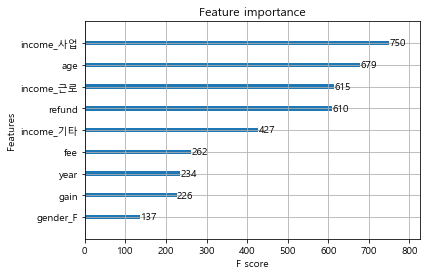

In [34]:
fig, ax = plt.subplots()
plot_importance(xgb_clf,ax=ax)

- 피어슨상관계수 히트맵에서 결제금액과 (사업소득 기타소득)이 상관관계가 있었는데, 여기서도 feature importance기준으로 상위에 속한다.
- 제일 높은 변수중요도를 가진 변수는 사업소득이고,두번쨰가 나이,3번째가 근로소득, 네번째가 환급액,5번째가 기타 소득에 해당한다.  
    => <U>이는 삼쩜삼 서비스를 이용해서 결제하는 주요 고객이 프리랜서일 수 있다는 의미로 해석할 수 있다.</U>
- 변수에 각 소득원의 유무(예: 근로yn)를 넣고 학습시켰을 때 소득원의 유무는 변수중요도가 높지 않았다. 

### 2. income 사업 변수 및 소득 데이터 분석
    - 그래프에서 보는 것처럼 결제고객의 사업소득 금액대 평균이 미결제고객의 금액대 보다 모든 연령그룹에서 훨씬 낮은 특징이 있다.
    - 다만, 최빈값을 기준으로 보면 다른 인사이트를 얻을 수 있다.  
    - 20세 이전과 26세에서 29세그룹, 34세부터 고연령층까지 사업소득의 최빈값이 구매고객 쪽이 더 높다.
    - 이를 사용하면 연령별로 income 소득의 최빈값을 기준으로하여 결제율을 상승시킬 수 있다.

#### 1) 연령별 결제여부별 각 소득 파악

#### (1) 사업소득

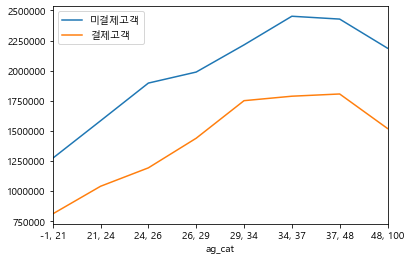

In [35]:
ag_p0=df.loc[df.income_사업.notnull(),:].query("has_paid==0").groupby('ag_cat')['income_사업'].mean()
ag_p0.name='미결제고객'
ag_p0.plot()
ag_p1=df.loc[df.income_사업.notnull(),:].query("has_paid==1").groupby('ag_cat')['income_사업'].mean()
ag_p1.name='결제고객'
ag_p1.plot()
plt.legend()

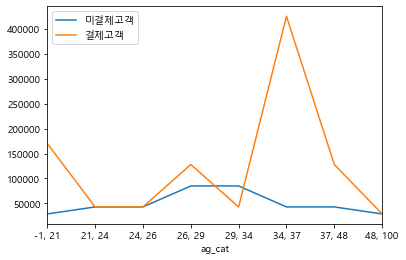

In [37]:
f1= lambda x: x.mode()
ag_p0=df.loc[df.income_사업.notnull(),:].query("has_paid==0").groupby('ag_cat')['income_사업'].agg(f1)
ag_p0.name='미결제고객'
ag_p0.plot()
ag_p1=df.loc[df.income_사업.notnull(),:].query("has_paid==1").groupby('ag_cat')['income_사업'].agg(f1)
ag_p1.name='결제고객'
ag_p1.plot()
plt.legend()

- 연령별 사업소득의 결제율을 높이기위한 값 설정

In [39]:
# 나이대별 결제율
l1=[]
l2=[]
for i in df.ag_cat.unique():
    str_expr="ag_cat == @i"
    str_expr1="ag_cat == @i and has_paid ==1"
    l1.append(df.query(str_expr1).shape[0]/df.query(str_expr).shape[0])
    l2.append(i)
    
age_cvr=pd.DataFrame([l2,l1]).T
age_cvr.columns=['age_bin','cvr']
age_cvr=age_cvr.set_index('age_bin').sort_values('cvr',ascending=False)
age_cvr

,cvr
age_bin,
"-1, 21",0.663146
"21, 24",0.653823
"26, 29",0.653374
"24, 26",0.652258
"29, 34",0.638193
"37, 48",0.625418
"34, 37",0.621988
"48, 100",0.616695


#### 사업소득 그룹화 (7개)

In [40]:
inc_comp_cat=pd.cut(df.income_사업,bins=[-1,df.income_사업.quantile(0.17),df.income_사업.quantile(0.17*2),
                     df.income_사업.quantile(0.17*3),df.income_사업.quantile(0.17*4),df.income_사업.quantile(0.17*5),df.income_사업.max()])
      #l,abels=['a','b','c','d','e','f'])
df['inc_comp_cat']=inc_comp_cat
df['inc_comp_cat']=df['inc_comp_cat'].astype('str')
df['inc_comp_cat']=df['inc_comp_cat'].replace('nan','n')
df

,age,gender,year,refund,fee,has_paid,income_근로,income_사업,income_기타,Target,pr,gain,ag_cat,근로yn,사업yn,기타yn,소득notnull여부,inc_comp_cat
0,27.0,F,2019,5000.0,400.0,0.0,10001000.0,61000.0,NaN,0.0,0.920000,4600.0,"26, 29",True,True,False,2,"(-1.0, 102000.0]"
1,34.0,M,2018,100000.0,1700.0,1.0,18092000.0,NaN,1815000.0,1700.0,0.983000,98300.0,"29, 34",True,False,True,2,n
2,28.0,F,2017,289000.0,11500.0,0.0,NaN,1461000.0,NaN,0.0,0.960208,277500.0,"26, 29",False,True,False,1,"(1233000.0, 2793000.0]"
3,27.0,M,2019,410000.0,16200.0,0.0,NaN,2471000.0,NaN,0.0,0.960488,393800.0,"26, 29",False,True,False,1,"(1233000.0, 2793000.0]"
4,26.0,F,2016,114000.0,4300.0,1.0,0.0,689000.0,NaN,4300.0,0.962281,109700.0,"24, 26",True,True,False,2,"(640000.0, 1233000.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,27.0,F,2019,301000.0,11900.0,1.0,NaN,NaN,680000.0,11900.0,0.960465,289100.0,"26, 29",False,False,True,1,n
99996,62.0,F,2019,77000.0,1300.0,1.0,NaN,463000.0,NaN,1300.0,0.983117,75700.0,"48, 100",False,True,False,1,"(295000.0, 640000.0]"
99997,24.0,M,2020,9000.0,400.0,0.0,7923000.0,54000.0,NaN,0.0,0.955556,8600.0,"21, 24",True,True,False,2,"(-1.0, 102000.0]"
99998,24.0,M,2019,34000.0,400.0,1.0,NaN,204000.0,NaN,400.0,0.988235,33600.0,"21, 24",False,True,False,1,"(102000.0, 295000.0]"


#### 사업소득 그룹별 결제율을 측정 (3번째로 낮은 수치의 사업소득그룹이 결제율은 높음)

In [42]:
f1= lambda x : x/x.sum()
df.groupby(['inc_comp_cat','has_paid'])['refund'].count().unstack().apply(f1,axis=1).iloc[:,1].sort_values(ascending=False)

inc_comp_cat
(295000.0, 640000.0]       0.781172
(102000.0, 295000.0]       0.763988
(640000.0, 1233000.0]      0.746281
(1233000.0, 2793000.0]     0.704518
(-1.0, 102000.0]           0.642573
(2793000.0, 39934000.0]    0.605438
n                          0.420716
Name: 1.0, dtype: float64

#### 나이대별 결제율은 60%대 이므로, 70%대의 전환율을 가진 사업소득그룹중 최솟값을 기준으로 필터링 후 나이대별 결제율 측정

In [131]:
# 사업 소득 변수에 결제율 70%대의 최소값 이상인 데이터를 넣은 나이대별 결제율 비교
l1=[]
l2=[]
for i in np.arange(0,ag_p1.shape[0]):
        l1.append(ag_p1.index[i])
        l2.append(df.query("income_사업>= 102000.0 and ag_cat==@ag_p1.index[@i]").has_paid.value_counts()[1]/df.query("income_사업>= 102000.0 and ag_cat==@ag_p1.index[@i]").shape[0])

age_mode_cvr=pd.DataFrame([l1,l2]).T
age_mode_cvr.columns=['age_bin','cvr']    
age_buis_cvr=age_mode_cvr.set_index('age_bin').sort_values('cvr',ascending=False)
age_buis_cvr['age_cvr']=age_cvr
age_buis_cvr

,cvr,age_cvr
age_bin,,
"26, 29",0.738617,0.653374
"34, 37",0.731175,0.621988
"29, 34",0.727812,0.638193
"24, 26",0.727063,0.652258
"21, 24",0.716702,0.653823
"37, 48",0.710381,0.625418
"-1, 21",0.702544,0.663146
"48, 100",0.697194,0.616695


In [44]:
(age_buis_cvr-age_cvr).sort_values(by='cvr',ascending=False).mean()

cvr    0.078324
dtype: float64

- <U> xgboost 모델의 feature selection에서 높은 중요도를 보인것처럼, income_사업 소득의 변화로 구매에 영향을 미칠 수 있음을 확인했다.</U>

#### (2) 기타소득
    - 기타소득 그룹화

In [95]:
inc_etc_cat=pd.cut(df.income_기타,bins=[-1,df.income_기타.quantile(0.17),df.income_기타.quantile(0.17*2),
                     df.income_기타.quantile(0.17*3),df.income_기타.quantile(0.17*4),df.income_기타.quantile(0.17*5),df.income_기타.max()])
      #l,abels=['a','b','c','d','e','f'])
df['inc_etc_cat']=inc_etc_cat
df['inc_etc_cat']=df['inc_etc_cat'].astype('str')
df['inc_etc_cat']=df['inc_etc_cat'].replace('nan','n')

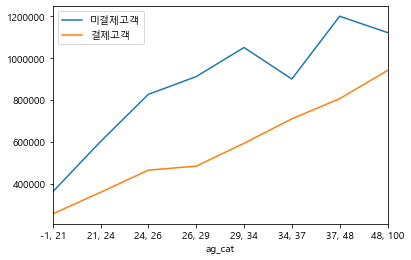

In [73]:
#기타소득 나이대별 평균
ag_p0=df.loc[df.income_기타.notnull(),:].query("has_paid==0").groupby('ag_cat')['income_기타'].mean()
ag_p0.name='미결제고객'
ag_p0.plot()
ag_p1=df.loc[df.income_기타.notnull(),:].query("has_paid==1").groupby('ag_cat')['income_기타'].mean()
ag_p1.name='결제고객'
ag_p1.plot()
plt.legend()

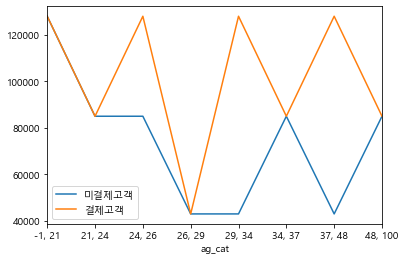

In [46]:
#기타소득 나이대별 최빈값
f1= lambda x: x.mode()[0]
ag_p0=df.loc[df.income_기타.notnull(),:].query("has_paid==0").groupby('ag_cat')['income_기타'].agg(f1)
ag_p0.name='미결제고객'
ag_p0.plot()
ag_p1=df.loc[df.income_기타.notnull(),:].query("has_paid==1").groupby('ag_cat')['income_기타'].agg(f1)
ag_p1.name='결제고객'
ag_p1.plot()
plt.legend()

In [74]:
f1= lambda x : x/x.sum()
df.groupby(['inc_etc_cat','has_paid'])['refund'].count().unstack().apply(f1,axis=1).iloc[:,1].sort_values(ascending=False)

inc_etc_cat
(51000.0, 114000.0]        0.690822
(114000.0, 213000.0]       0.688810
(-1.0, 51000.0]            0.686903
(213000.0, 425000.0]       0.682455
(425000.0, 1020000.0]      0.660925
n                          0.641813
(1020000.0, 62810000.0]    0.536968
Name: 1.0, dtype: float64

In [133]:
# 기타 소득 변수에 의한 필터링으로 나이대별 결제율 비교
l1=[]
l2=[]
for i in np.arange(0,ag_p1.shape[0]):
        l1.append(ag_p1.index[i])
        l2.append(df.query("income_기타>= 51000 and ag_cat==@ag_p1.index[@i]").has_paid.value_counts()[1]/df.query("income_기타>= 51000 and ag_cat==@ag_p1.index[@i]").shape[0])

age_mode_cvr=pd.DataFrame([l1,l2]).T
age_mode_cvr.columns=['age_bin','cvr']    
age_etc_cvr=age_mode_cvr.set_index('age_bin').sort_values('cvr',ascending=False)
age_etc_cvr['age_cvr']=age_cvr
age_etc_cvr.sort_index()

,cvr,age_cvr
age_bin,,
"-1, 21",0.68244,0.663146
"21, 24",0.636502,0.653823
"24, 26",0.638557,0.652258
"26, 29",0.664028,0.653374
"29, 34",0.647432,0.638193
"34, 37",0.668863,0.621988
"37, 48",0.702674,0.625418
"48, 100",0.642029,0.616695


- 기타 소득의 경우 위치기준 기타소득범위의 17%에 해당하는 값이나 1로 필터링하면, 21세부터 26세까지의 결제율은 낮아지고 나머지는 높아진다.
- <U>필터링 없는 경우와 비교하면  34세 이상의 결제율 상승에 기타소득의 유무나 최소값설정으로 필터링을 하는 것이 결제율에 영향이 있다.</U> 

#### (3) 근로소득
    - 근로소득 범주화

In [134]:
inc_lab_cat=pd.cut(df.income_근로,bins=[-1,df.income_근로.quantile(0.17),df.income_근로.quantile(0.17*2),
                     df.income_근로.quantile(0.17*3),df.income_근로.quantile(0.17*4),df.income_근로.quantile(0.17*5),df.income_근로.max()])
      #l,abels=['a','b','c','d','e','f'])
df['inc_lab_cat']=inc_lab_cat
df['inc_lab_cat']=df['inc_lab_cat'].astype('str')
df['inc_lab_cat']=df['inc_lab_cat'].replace('nan','n')

In [142]:
df.inc_lab_cat.value_counts()

n                            59187
(4651000.0, 7742000.0]        6935
(-1.0, 993300.0]              6935
(2457600.0, 4651000.0]        6935
(993300.0, 2457600.0]         6934
(7742000.0, 12228500.0]       6933
(12228500.0, 182335000.0]     6119
Name: inc_lab_cat, dtype: int64

In [150]:
# 근로 소득 카테고리에서 최소값기준으로 필터링하여 결제율 비교
l1=[]
l2=[]
for i in np.arange(0,ag_p1.shape[0]):
        l1.append(ag_p1.index[i])
        l2.append(df.query("income_근로>= 993300 and ag_cat==@ag_p1.index[@i]").has_paid.value_counts()[1]/df.query("income_근로>= 993300 and ag_cat==@ag_p1.index[@i]").shape[0])

age_mode_cvr=pd.DataFrame([l1,l2]).T
age_mode_cvr.columns=['age_bin','cvr']    
age_lab_cvr=age_mode_cvr.set_index('age_bin').sort_values('cvr',ascending=False)
age_lab_cvr['age_cvr']=age_cvr
age_lab_cvr.sort_index()

,cvr,age_cvr
age_bin,,
"-1, 21",0.663991,0.663146
"21, 24",0.688779,0.653823
"24, 26",0.701689,0.652258
"26, 29",0.702118,0.653374
"29, 34",0.695729,0.638193
"34, 37",0.70194,0.621988
"37, 48",0.711419,0.625418
"48, 100",0.703676,0.616695


In [156]:
(age_lab_cvr['cvr']-age_lab_cvr['age_cvr']).mean()

0.05555575478494797

- 근로소득의 필터링을 통해 모든 연령층에서 결제율 전환을 상승을 관찰할 수 있다.
- 그러므로, 근로소득도 결제여부에 영향을 주는 변수라고 볼 수 있다.
- 다만 차이값의 평균으로 보면 3가지 소득에서 전체를 동일기준으로 하면 사업 > 근로 > 기타 순으로 결제여부에 영향을 주는 것으로 추측할 수 있다.

### 3. AGE 변수 분석 

#### 1) 통계적 방법으로 독립성 검정을 통해 나이 카테고리변수와 결제여부컬럼의 독립성을 확인한다.

- 독립성 검정은  두 factor 변수사이에 '귀무가설 : 독립이다. / 대립가설 : 독립이 아니다.' 를 의미한다.
- 카이제곱검정을 통한 P_value가 0.05보다 작으면 귀무가설은 기각되고 대립가설이 채택된다.  
- 주어진 데이터에서 나이카테고리와 지불여부에 대한 독립성검정시 pvalue가 0.05보다 작아 대립가설이 채택되고 서로 관련이 있다고 볼 수 있다.

In [54]:
from scipy.stats import chi2_contingency
df_age=pd.crosstab(df.ag_cat,df.has_paid)
p_value=chi2_contingency(df_age)[1]
(p_value,p_value<0.05)

(2.5428346424485214e-12, True)

#### 2) 데이터 그룹별 결제수 합과 결제율을 비교한다.

- 21-24세, 26-29세가 가장 결제 규모가 높고 34세까지는 높은 편에 속한다.
- age_cvr은 위에서 만든 나이별 전체 데이터의 결제율데이터이다.
- 결제율은 20세 이하의 데이터가 1등이기 때문에, 결제 규모의 순위와는 차이가 있다고 볼 수 있다.
- 하지만, 결제율을 비교하면 34세 이상의 나이가 하위권이고 그 이전의 나이대는 상위권인것처럼 전체적인 추세는 규모를 비교한 것과 비슷하다.
- <U>결국 34세 미만의 연령에 해당하는지의 여부가 결제여부에 영향을 미치는 것으로 볼 수 있다.</U>

In [55]:
# 나이대별 결제 데이터 합의 규모를 보기 위한 것이다.
a=df.groupby('ag_cat')['has_paid'].sum().sort_values(ascending=False)
a

ag_cat
21, 24     14050.0
26, 29     13992.0
24, 26     11770.0
29, 34      9705.0
37, 48      4862.0
-1, 21      4835.0
34, 37      2891.0
48, 100     2534.0
Name: has_paid, dtype: float64

(0.5, 0.8)

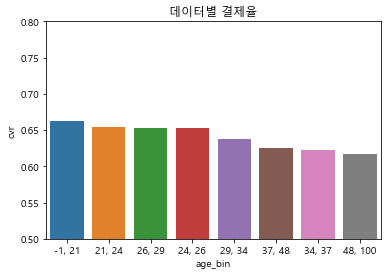

In [181]:
sns.barplot(age_cvr.index,age_cvr.cvr)
plt.title('나이대 데이터별 결제율')
plt.ylim(0.5, 0.8)

Text(0.5, 1.0, '나이대별 결제 데이터 합의 규모')

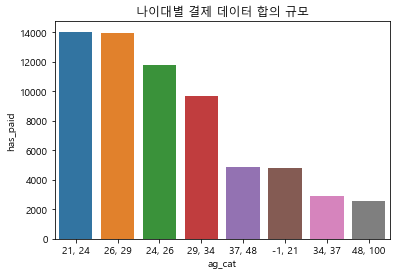

In [179]:
sns.barplot(x=a.index,y=a)
plt.title('나이대별 결제 데이터 합의 규모')

- 결제율과 나이대별 구매 규모를 고려한 변수 생성( 결제규모 x 결제율)
- 변수의 값을 보면, 34세 이전에 해당하는 그룹의 값과 아닌값의 차이가 약 2배 넘게 차이난다.
- 즉, <U>특정 연령 그룹에 해당하는지의 여부가 구매여부에 영향을 주는 것으로 파악된다.</U>

In [58]:
a2=(age_cvr[['cvr']].sort_index().transpose()*a.sort_index()).T
a2.columns=['variable']
a2.sort_values(by='variable',ascending=False)

,variable
age_bin,
"21, 24",9186.21
"26, 29",9142.01
"24, 26",7677.08
"29, 34",6193.66
"-1, 21",3206.31
"37, 48",3040.78
"34, 37",1798.17
"48, 100",1562.71


### 4. refund 변수 분석 
#### 1) 히스토그램을 통한 데이터 파악 및 범주화로 결제율 개선
    - 결제여부에 따라 환불액은 미결제 데이터가 1745개 결제데이터가 1521개로 차이가 있다.
    - 그리고 상위빈도 환불액의 경우, 크기차이가 있어 빈도수와 환불액을 곱한 수치의 합을 비교하겠다.
    - 이렇게 하면 높은 환불액에 빈도수가 높을 경우 더 높은 수치를 얻을 수 있다. 

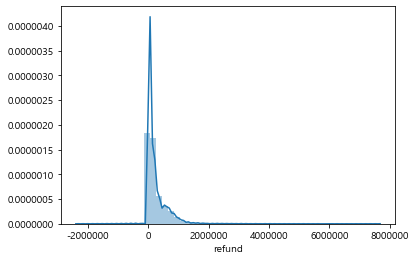

In [207]:
sns.distplot(df.query("has_paid==0")['refund'],bins=50)

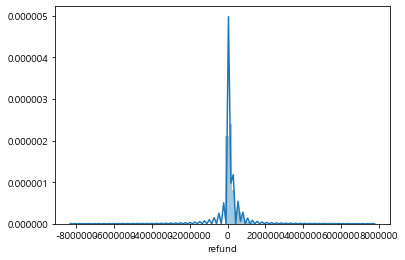

In [209]:
sns.distplot(df.query("has_paid==1")['refund'],bins=100)

In [237]:
# 환불액을 3가지 범주 데이터로 변환
df=df.sort_values(by='refund')
l1=[]
for i in range(df.shape[0]):
    if i > df.shape[0]*0.66:
        l1.append('a')
    elif i > df.shape[0]*0.33:
        l1.append('b')
    else:
        l1.append('c')

df['ref_cat']=l1
df['ref_cat']

98352    c
52858    c
55168    c
54256    c
94281    c
        ..
30513    a
2374     a
47635    a
11235    a
61745    a
Name: ref_cat, Length: 99978, dtype: object

In [230]:
f1= lambda x: x/x.sum()
df.groupby(['ref_cat','has_paid'])['age'].count().unstack().apply(f1,axis=1)

has_paid,0.0,1.0
ref_cat,,
a,0.391386,0.608614
b,0.308399,0.691601
c,0.359470,0.640530


In [235]:
(df.iloc[round(df.shape[0]*0.33),:].refund,df.iloc[round(df.shape[0]*0.66),:].refund)

(48000.0, 180000.0)

- 연령 데이터에서 b 그룹에 해당하는 refund 값으로 필터링하여 전체 연령 그룹의 결제율 개선확인
- <U> 즉, 환급액은 결제 여부에 영향을 미친다.</U>

In [238]:
l1=[]
l2=[]
for i in np.arange(0,ag_p1.shape[0]):
        l1.append(ag_p1.index[i])
        l2.append(df.query("refund >= 48000 and refund <= 180000 and ag_cat==@ag_p1.index[@i]").has_paid.value_counts()[1]/df.query("refund >= 48000 and refund <= 180000 and ag_cat==@ag_p1.index[@i]").shape[0])

age_mode_cvr=pd.DataFrame([l1,l2]).T
age_mode_cvr.columns=['age_bin','cvr']    
age_ref_cvr=age_mode_cvr.set_index('age_bin').sort_values('cvr',ascending=False)
age_ref_cvr['age_cvr']=age_cvr
age_ref_cvr.sort_index()

,cvr,age_cvr
age_bin,,
"-1, 21",0.731395,0.663146
"21, 24",0.703872,0.653823
"24, 26",0.694764,0.652258
"26, 29",0.69403,0.653374
"29, 34",0.668028,0.638193
"34, 37",0.650507,0.621988
"37, 48",0.676407,0.625418
"48, 100",0.663415,0.616695


### 5.  year변수분석과 결제금액 총합계 증대방안
#### 1)  연도에 따른 변화 분석

- 19년 이전까지는 연별 결제율이 감소하였으나 20년에 급감했다.
- 19년도 까지는 연도가 지나면서 결제 규모와 여부가 증가했다. 
- 연도별 총 유입의 증가폭은 2019년까지 감소하다가 20년에 반등했다.
- 20년도는 미결제 데이터의 수는 금증하고 결제 데이터는 급감하였다.
- 19년부터 20년사이에 결제데이터의 수가 감소하고 예상환불액합계는 오히려 미결제자 측에서 급격히 증가하는 등 추세가 최근에 변하였다.

In [67]:
# 년도별 결제율 출력
l1=[]
l2=[]
for i in df.year.unique():
    str_expr="year == @i"
    str_expr1="year == @i and has_paid ==1"
    l1.append(df.query(str_expr1).shape[0]/df.query(str_expr).shape[0])
    l2.append(i)
    
y_cvr=pd.DataFrame([l2,l1]).T
y_cvr.columns=['year','cvr']
y_cvr=y_cvr.set_index('year').sort_values('cvr',ascending=False)
y_cvr

,cvr
year,
2015.0,0.711307
2017.0,0.697633
2016.0,0.697124
2018.0,0.695115
2019.0,0.694999
2020.0,0.485241


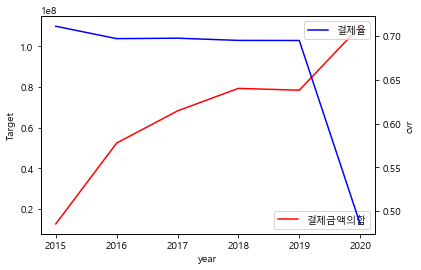

In [68]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.lineplot(df.groupby('year')['Target'].sum().index,df.groupby('year')['Target'].sum(),label='결제금액의합',ax=ax1,color='red')
sns.lineplot(y_cvr.index,y_cvr['cvr'],label='결제율',ax=ax2,color='blue')
ax1.legend(loc="lower right")
ax2.legend()

Text(0.5, 1.0, '연도별 결제여부별 데이터의 수의 합계')

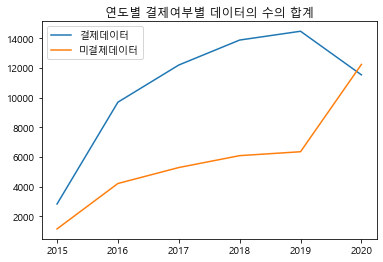

In [241]:
df_y_hp=df.groupby(['year','has_paid'])['age'].count()
df_y_hp.name='count'
df_y_hp=df_y_hp.reset_index()
df_y_hp1=df_y_hp.query("has_paid==1")
df_y_hp0=df_y_hp.query("has_paid==0")
plt.plot(df_y_hp1.year,df_y_hp1['count'],label='결제데이터')
plt.plot(df_y_hp0.year,df_y_hp0['count'],label='미결제데이터')
plt.legend()
plt.title('연도별 결제여부별 데이터의 수의 합계')

- 결제데이터가 급격히 줄고, 미결제 데이터가 급격히 늘었으니 결제율이 급락하는 것은 당연하다.

Text(0.5, 1.0, '연도별 결제여부별 순 환급액의 평균')

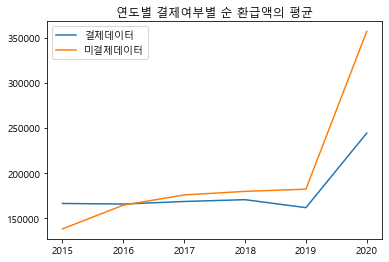

In [250]:
plt.plot(df.query("has_paid==1").groupby('year')['refund'].sum().index,df.query("has_paid==1").groupby('year')['gain'].mean(),label='결제데이터')
plt.plot(df.query("has_paid==0").groupby('year')['refund'].sum().index,df.query("has_paid==0").groupby('year')['gain'].mean(),label='미결제데이터')
plt.legend()
plt.title('연도별 결제여부별 순 환급액의 평균')

- 순환급액 때문에 2020년에 결제고객과 결제율이 급감한 것은 아니다.

Text(0.5, 1.0, '연도별 결제고객별 결제금액의 평균값')

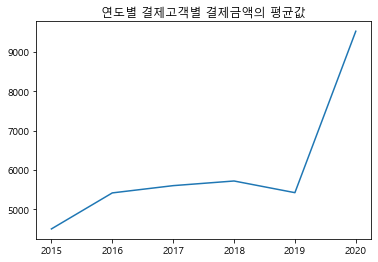

In [260]:
plt.plot(df.query("has_paid==1").groupby('year')['Target'].sum().index,df.query("has_paid==1").groupby('year')['Target'].mean(),label='결제데이터')
plt.title('연도별 결제고객별 결제금액의 평균값')

- 여기까지 보면 전체 데이터에서 년도가 지나며 지속적인 추세는 없고, 20년 기준으로 급격한 변화가 발생한다.
- 이러한 현상은 삼쩜삼 서비스 오픈이 20년 3월에 있었기 때문으로 추정한다.

Text(0.5, 1.0, '연도별 결제고객별 결제금액의 총합계')

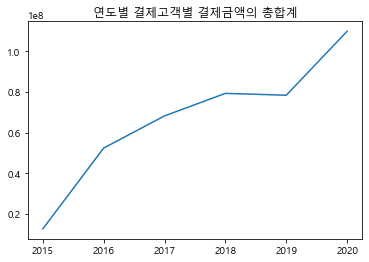

In [262]:
plt.plot(df.query("has_paid==1").groupby('year')['Target'].sum().index,df.query("has_paid==1").groupby('year')['Target'].sum(),label='결제데이터')
plt.title('연도별 결제고객별 결제금액의 총합계')

- 미결제 데이터의 수와 결제 데이터의 수가 20년도에 교차되더라도 결제 금액총합은 지속적으로 증가한다.
- 또한, 고객마다의 순 환급액도 증가했다. 다만, 미결제 고객의 순 환급액 평균이 더 높다.
- 총결제 고객수도 꾸준히 증가한다.

Text(0.5, 1.0, '연도별 총 고객 수')

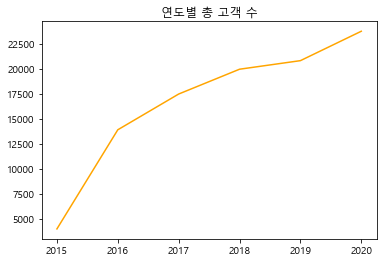

In [267]:
plt.plot(df.groupby('year')['age'].count(),color='orange')
plt.title('연도별 총 고객 수')

- 추가로 년도별 사업소득 그룹별로 차지하는 비중을 살펴보겠다.

In [257]:
f1= lambda x: x / x.sum() 
pd.crosstab(df.year,df.inc_comp_cat).apply(f1,axis=1)

inc_comp_cat,"(-1.0, 102000.0]","(102000.0, 295000.0]","(1233000.0, 2793000.0]","(2793000.0, 39934000.0]","(295000.0, 640000.0]","(640000.0, 1233000.0]",n
year,,,,,,,
2015,0.093216,0.123869,0.101005,0.066332,0.116332,0.102010,0.397236
2016,0.148095,0.142344,0.125018,0.083178,0.138677,0.127318,0.235370
2017,0.142579,0.139378,0.125314,0.089698,0.142522,0.134576,0.225932
2018,0.137001,0.139654,0.124837,0.088948,0.132095,0.139654,0.237812
2019,0.130543,0.137790,0.126224,0.077654,0.146285,0.146717,0.234786
2020,0.124254,0.113826,0.160752,0.224834,0.114246,0.123287,0.138802


In [268]:
pd.crosstab(df.year,df.inc_lab_cat).apply(f1,axis=1)

inc_lab_cat,"(-1.0, 993300.0]","(12228500.0, 182335000.0]","(2457600.0, 4651000.0]","(4651000.0, 7742000.0]","(7742000.0, 12228500.0]","(993300.0, 2457600.0]",n
year,,,,,,,
2015,0.012060,0.011558,0.009548,0.007538,0.007538,0.011558,0.940201
2016,0.075341,0.041912,0.063911,0.066427,0.046873,0.063839,0.641697
2017,0.079522,0.044592,0.064144,0.067574,0.052653,0.072547,0.618969
2018,0.069727,0.058414,0.064921,0.068075,0.069076,0.064921,0.604865
2019,0.065512,0.076022,0.073191,0.074246,0.083749,0.072135,0.555145
2020,0.071062,0.082373,0.086788,0.079556,0.092717,0.081196,0.506307


In [269]:
pd.crosstab(df.year,df.inc_etc_cat).apply(f1,axis=1)

inc_etc_cat,"(-1.0, 51000.0]","(1020000.0, 62810000.0]","(114000.0, 213000.0]","(213000.0, 425000.0]","(425000.0, 1020000.0]","(51000.0, 114000.0]",n
year,,,,,,,
2015,0.029648,0.008040,0.013568,0.012563,0.012563,0.016332,0.907286
2016,0.040043,0.037527,0.050683,0.042416,0.039756,0.029331,0.760244
2017,0.040590,0.037217,0.046879,0.044020,0.041105,0.030814,0.759376
2018,0.048253,0.035940,0.045250,0.042647,0.045600,0.043748,0.738562
2019,0.047034,0.031580,0.048714,0.041803,0.043914,0.052985,0.733970
2020,0.044950,0.049575,0.043436,0.042259,0.045833,0.050669,0.723278


In [273]:
pd.crosstab(df.year,df.ref_cat).apply(f1,axis=1)

ref_cat,a,b,c
year,,,
2015,0.284925,0.321357,0.393719
2016,0.294177,0.332566,0.373257
2017,0.305397,0.335468,0.359136
2018,0.302132,0.341426,0.356442
2019,0.297850,0.352755,0.349395
2020,0.470188,0.296401,0.233412


In [276]:
pd.crosstab(df.year,df.ag_cat).apply(f1,axis=1)

ag_cat,"-1, 21","21, 24","24, 26","26, 29","29, 34","34, 37","37, 48","48, 100"
year,,,,,,,,
2015,0.005528,0.095980,0.210050,0.299246,0.196482,0.050754,0.090452,0.051508
2016,0.013012,0.153918,0.177283,0.261826,0.188785,0.059310,0.094033,0.051833
2017,0.028184,0.206151,0.185628,0.234736,0.168420,0.048994,0.083753,0.044134
2018,0.070427,0.229102,0.186105,0.209881,0.141956,0.046201,0.076134,0.040194
2019,0.114033,0.239297,0.178009,0.184728,0.134863,0.041755,0.071511,0.035803
2020,0.118241,0.243756,0.171096,0.186444,0.134850,0.040829,0.068539,0.036246


In [277]:
pd.crosstab(df.inc_comp_cat,df.ag_cat).apply(f1,axis=1)

ag_cat,"-1, 21","21, 24","24, 26","26, 29","29, 34","34, 37","37, 48","48, 100"
inc_comp_cat,,,,,,,,
"(-1.0, 102000.0]",0.102197,0.237085,0.184899,0.200270,0.130839,0.040339,0.065007,0.039364
"(102000.0, 295000.0]",0.096393,0.247082,0.183749,0.200768,0.132239,0.035620,0.066345,0.037804
"(1233000.0, 2793000.0]",0.066190,0.205949,0.177636,0.216943,0.160617,0.048946,0.079217,0.044503
"(2793000.0, 39934000.0]",0.040402,0.159052,0.159990,0.230907,0.195960,0.059325,0.105268,0.049096
"(295000.0, 640000.0]",0.094213,0.245466,0.189856,0.204154,0.128527,0.035744,0.064489,0.037550
"(640000.0, 1233000.0]",0.078287,0.244929,0.184072,0.208715,0.138242,0.040721,0.064914,0.040120
n,0.046021,0.180360,0.180681,0.229737,0.171302,0.058572,0.092777,0.040550


In [278]:
pd.crosstab(df.inc_comp_cat,df.gender).apply(f1,axis=1)

gender,F,M
inc_comp_cat,,
"(-1.0, 102000.0]",0.505961,0.494039
"(102000.0, 295000.0]",0.525416,0.474584
"(1233000.0, 2793000.0]",0.489081,0.510919
"(2793000.0, 39934000.0]",0.441783,0.558217
"(295000.0, 640000.0]",0.520129,0.479871
"(640000.0, 1233000.0]",0.506912,0.493088
n,0.479932,0.520068


- 사업소득이 없는 데이터가 23%대에서 13%대로 급감하고, 사업소득이 2,793,000 에서 39,934,000 범위인 데이터가 3배 증가했다.
- 그외, 사업 소득이 1233000에서 2793000까지에 속한 그룹의 데이터 비중도 증가했다.
- 근로소득의 경우나 기타소득의 경우에는 이에 비해 결측값 감소나 특정그룹의 비율 변화정도가 작은편이다.
- 환급액 각 그룹별 비중은 사업소득처럼 큰 변화가 있다. 제일 고액의 그룹인 a그룹이 증가하였다.
- 반면, 제일 저액의 그룹인 c그룹(약 11%)이 가장 많이 감소하고 중간액의 그룹은 덜 감소하였다.
- 나이그룹의 변화는 거의 없는것으로 보인다.

### 2020년 결제금액 총합계의 증가와 변수들의 변화에 대해 정리하면 매출액 총 합계를 증가시키키 위해 다음의 결론을 내릴 수 있다.
    1. 2020년에 결제금액의 평균값과 총합계가 급증했다.
    2. 오히려 총 결제율과 결제데이터의 수는 하락하였다.
    3. 사업소득이 2,793,000 에서 39,934,000 범위(최상위)에 해당하는 고객은 2020년 다른해에 비해 3배이상 증가하였다.
    4. 사업소득 최상위 그룹은 26세 이상의 고객의 비율이 다른 사업소득 그룹보다 높고, 남성의 비율이 다른 사업소득 그룹보다 높다.
    5. 위 3가지 기준에 해당하는 고객이 가장 많이 쓰는 플랫폼에서 해당 그룹을 타게팅하여 지속적으로 마케팅할 경우 결제 금액  
       총합계의 증대를 예상할 수 있다.